In this notebook, we will use 3 visualization techniques to convey the meaning of some extremely basic NFL data
<br>
<br>
First we import our packages including two classifiers we will apply on the data set

In [58]:
import numpy as np
import pandas as pd

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
df = pd.read_csv('./Data/nfl_games.csv', parse_dates = [0], index_col = "date")
df = df.dropna()
df.tail()


,season,neutral,playoff,team1,team2,elo1,elo2,elo_prob1,score1,score2,result1
date,,,,,,,,,,,
2019-01-13,2018,0,1,NE,LAC,1640.171960,1647.624483,0.582068,41,28,1.0
2019-01-13,2018,0,1,NO,PHI,1669.105861,1633.114673,0.641378,20,14,1.0
2019-01-20,2018,0,1,NO,LAR,1682.450194,1648.424105,0.638772,23,26,0.0
2019-01-20,2018,0,1,KC,NE,1675.286412,1661.668566,0.611248,31,37,0.0
2019-02-03,2018,1,1,LAR,NE,1666.969395,1686.338837,0.472154,3,13,0.0


## Visualization 1

First we will explore how total score of each game changes over time<br>
We add the score1 and score2 columns and keep only season scores and mean<br><br>
This gives us the average score per game for each season for the entire NFL

In [62]:
avgScorePerSeason = df
avgScorePerSeason = avgScorePerSeason.drop(avgScorePerSeason.columns[[1,2,3,4,5,6,7,10]], axis=1)
avgScorePerSeason['totalScore'] = avgScorePerSeason['score1'] + avgScorePerSeason['score2']
avgScorePerSeason['seasonMean'] = avgScorePerSeason.groupby('season')['totalScore'].transform('mean')
avgScorePerSeason.tail()

,season,score1,score2,totalScore,seasonMean
date,,,,,
2019-01-13,2018,41,28,69,46.550562
2019-01-13,2018,20,14,34,46.550562
2019-01-20,2018,23,26,49,46.550562
2019-01-20,2018,31,37,68,46.550562
2019-02-03,2018,3,13,16,46.550562


Let's start with a simple yet effective visualization. We use a scatter plot to the plot the average score per game for each season in red. In blue we also plot the scores for each game since 1920. 

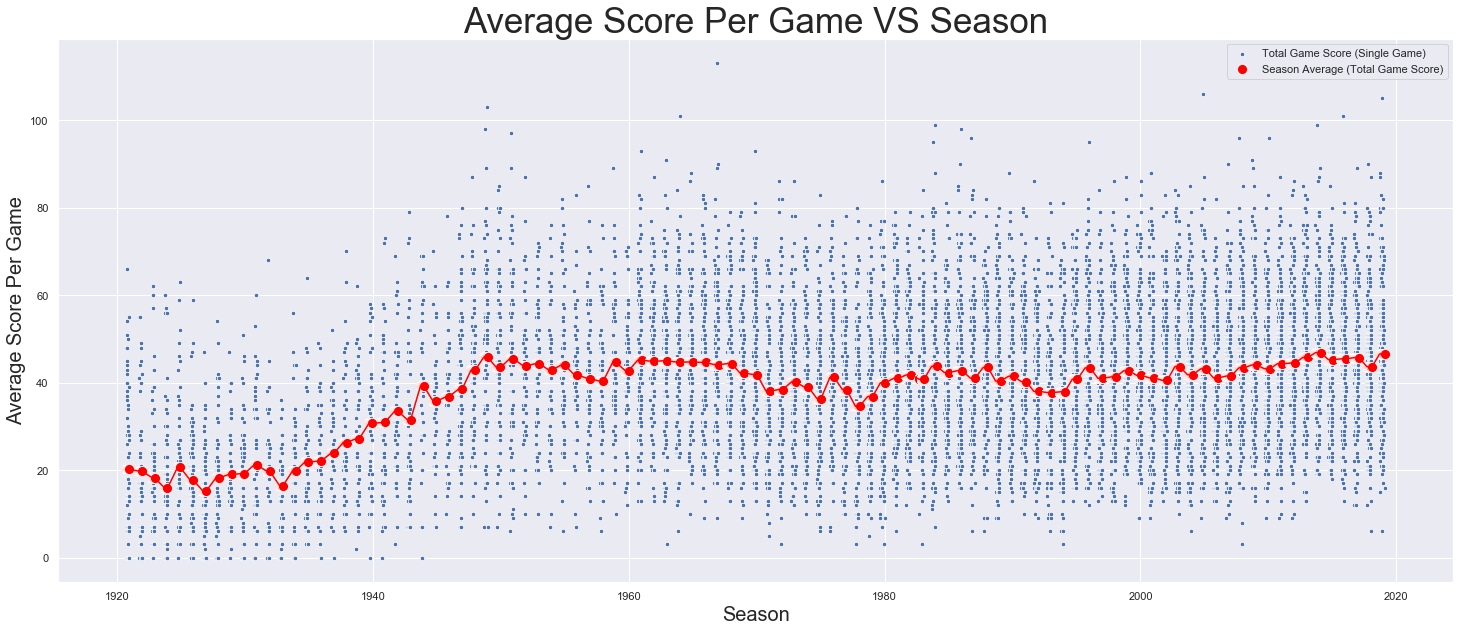

In [64]:
fig = plt.figure(figsize = (25, 10))
ax = sns.scatterplot(x=avgScorePerSeason.index, y="totalScore", data=avgScorePerSeason, zorder=1, s=20, label='Total Game Score (Single Game)')
ax = sns.scatterplot(x=avgScorePerSeason.index, y="seasonMean", data=avgScorePerSeason, zorder=2, s=100, color='red', label='Season Average (Total Game Score)')
ax = sns.lineplot(x=avgScorePerSeason.index, y="seasonMean", data=avgScorePerSeason, zorder=3, color='red', ci=95, ax=ax)
ax.legend()
plt.title('Average Score Per Game VS Season', fontsize=35)
plt.ylabel('Average Score Per Game', fontsize=20)
plt.xlabel('Season', fontsize=20);


We see that the average trended up until 1950 and then it trends sideways<br><br>
# Visualization 2
If we use only the post 1950 data we can look at how the average score per season for a single team changes over time<br>
If draft rules are effective, teams should mean revert to an consistent average score per game from season to season<br><br>
We begin by combining the team1 and team2 columns and their scores, and then finding the mean of each team for each season<br>


In [67]:
avgScrTeam1PerYr = df[df['season'] >= 1965]
avgScrTeam1PerYr.head()

avgScrTeam1PerYr = avgScrTeam1PerYr.drop(avgScrTeam1PerYr.columns[[1,2,4,5,6,7,9,10]], axis=1)
avgScrTeam1PerYr['seasonMeanTeam'] = avgScrTeam1PerYr.groupby(['season', 'team1'])['score1'].transform('mean')
avgScrTeam1PerYr = avgScrTeam1PerYr.rename(columns={'team1': 'team', 'score1' : 'score'})
    
avgScrTeam2PerYr = df[df['season'] > 1965]
avgScrTeam2PerYr = avgScrTeam2PerYr.drop(avgScrTeam2PerYr.columns[[1,2,3,5,6,7,8,10]], axis=1)
avgScrTeam2PerYr['seasonMeanTeam'] = avgScrTeam2PerYr.groupby(['season', 'team2'])['score2'].transform('mean')
avgScrTeam2PerYr = avgScrTeam2PerYr.rename(columns={'team2': 'team', 'score2' : 'score'})
    
frames = [avgScrTeam1PerYr, avgScrTeam2PerYr]
avgScrPerTeamEachYr = pd.concat(frames, sort=True)

# verify we have all occurances of the team
assert(avgScrTeam1PerYr['team'].count() + avgScrTeam2PerYr['team'].count() == avgScrPerTeamEachYr['team'].count())

avgScrPerTeamEachYr.head()


,score,season,seasonMeanTeam,team
date,,,,
1965-09-11,34,1965,20.375000,LAC
1965-09-11,24,1965,22.714286,BUF
1965-09-12,37,1965,22.285714,OAK
1965-09-12,27,1965,26.000000,TEN
1965-09-18,10,1965,23.714286,NYJ


Now drop the duplicates so that our data is not redundant

In [68]:
avgScrPerTeamEachYr = avgScrPerTeamEachYr.drop_duplicates(subset=['team', 'season'], keep='first')

Let's plot the data for each team<br>
We'll make two plots to make the data easier to see<br>
and include a line of best fit

C:\Users\Daniel\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


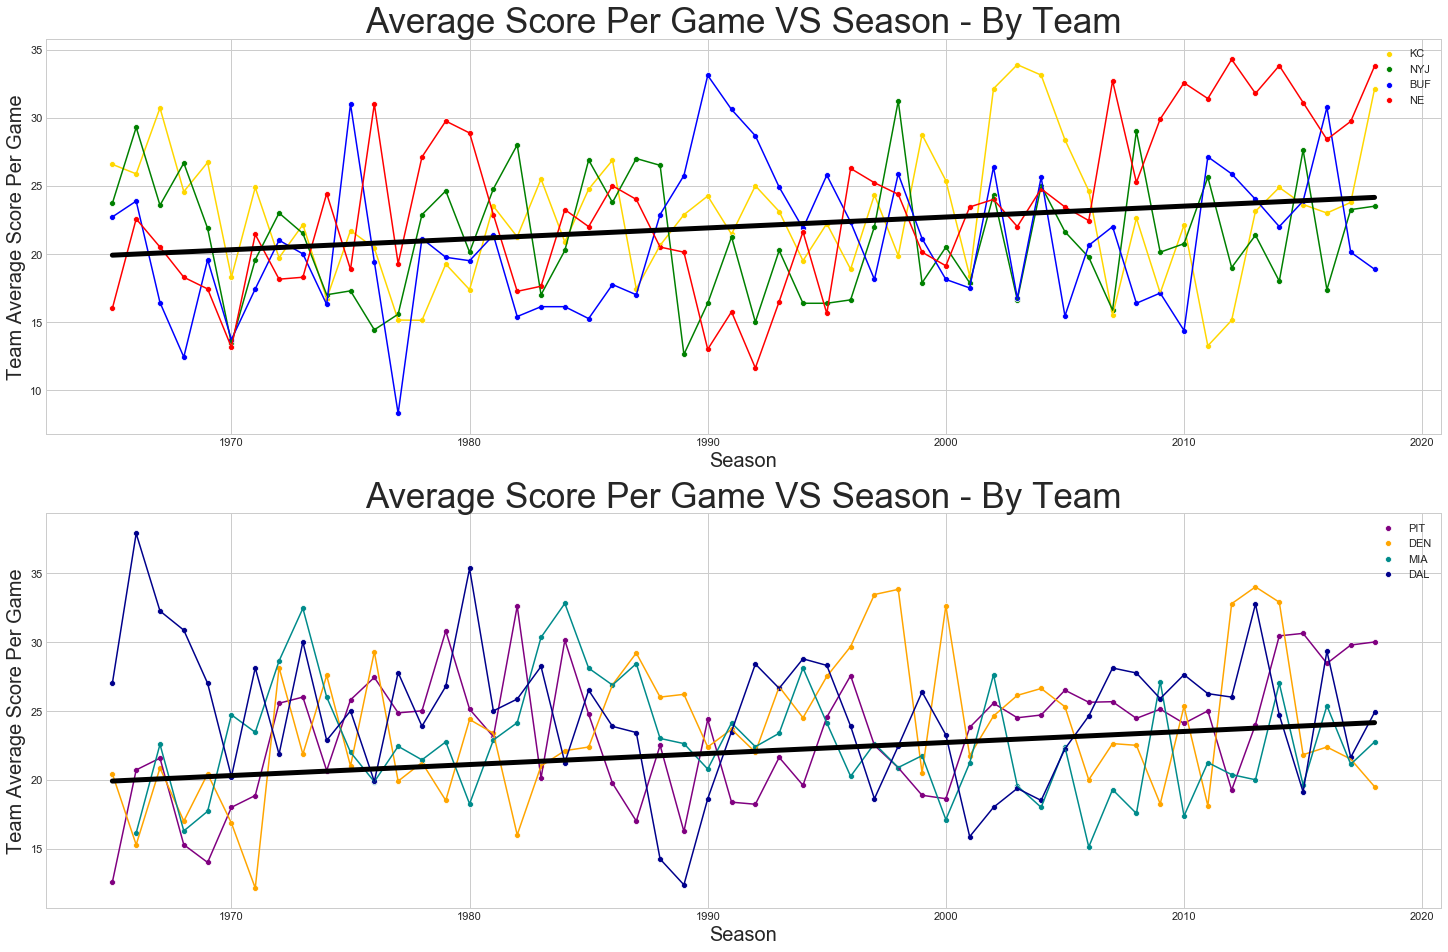

In [69]:
from sklearn import preprocessing

fig = plt.figure(figsize = (25, 16))
def plotTeam(teamName, c):
    
    t = avgScrPerTeamEachYr.loc[avgScrPerTeamEachYr['team'] == teamName]
    t['date'] = t.index
    ax = sns.scatterplot(x='season', y="seasonMeanTeam",  data=t, color=c, label=teamName)
    ax = sns.lineplot(x='season', y="seasonMeanTeam",  data=t, color=c)
    
    ax.legend(loc='upper right')
    plt.ylabel('Team Average Score Per Game', fontsize=20)
    plt.xlabel('Season', fontsize=20)
    plt.title('Average Score Per Game VS Season - By Team', fontsize=35)
    


t1 = avgScrPerTeamEachYr.loc[avgScrPerTeamEachYr['team'] == 'KC' ]
t2 = avgScrPerTeamEachYr.loc[avgScrPerTeamEachYr['team'] == 'NYJ' ]
t3 = avgScrPerTeamEachYr.loc[avgScrPerTeamEachYr['team'] == 'BUF' ]
t4 = avgScrPerTeamEachYr.loc[avgScrPerTeamEachYr['team'] == 'NE' ]

frames = [t1,t2,t3,t4]

t = pd.concat(frames, sort=True)

x=t['season']
y=t['seasonMeanTeam']

plt.subplot(2,1,1)  
plotTeam('KC', 'gold')
plotTeam('NYJ', 'green')
plotTeam('BUF', 'blue')
plotTeam('NE', 'red')
plt.plot( np.unique(x), np.poly1d(np.polyfit(x,y,1))(np.unique(x)), color='black', linewidth=5 )


t1 = avgScrPerTeamEachYr.loc[avgScrPerTeamEachYr['team'] == 'PIT' ]
t2 = avgScrPerTeamEachYr.loc[avgScrPerTeamEachYr['team'] == 'DEN' ]
t3 = avgScrPerTeamEachYr.loc[avgScrPerTeamEachYr['team'] == 'MIA' ]
t4 = avgScrPerTeamEachYr.loc[avgScrPerTeamEachYr['team'] == 'DAL' ]

frames = [t1,t2,t3,t4]

t = pd.concat(frames, sort=True)


plt.subplot(2,1,2)  
plotTeam('PIT', 'purple')
plotTeam('DEN', 'orange')
plotTeam('MIA', 'darkcyan')
plotTeam('DAL', 'darkblue')
plt.plot( np.unique(x), np.poly1d(np.polyfit(x,y,1))(np.unique(x)), color='black', linewidth=5 );

As shown in the graphs above, the average game score for each team mean reverts toward an average of 20 points per game<br>
Note that this only coniders teams that have been around since 1965 and only considers the games after 1965
<br>Again this was chosen because the average score per season stabalized after the 1950's
# Visualization 3

Now we will zoom in on the most recent complete season (2018) and look at the distribution of elo.

In [73]:
# drop all data except the 2018 season
season = df.loc[df['season'] == 2018 ]
# make all rows unique by team for 32 rows
season = season.drop_duplicates(subset=['team1'], keep='first')

#verify we have all 32 teams in the nfl
assert(season['team1'].count() == 32)
# drop unused columns
season = season.drop(season.columns[[1,2,4,6,7,8,9,10]], axis=1)
season['elo1'].describe()
#avgScrTeam1PerYr = avgScrTeam1PerYr.drop(avgScrTeam1PerYr.columns[[1,2,4,5,6,7,9,10]], axis=1)

count      32.000000
mean     1507.903657
std        77.439951
min      1301.910164
25%      1463.594383
50%      1505.997105
75%      1552.568201
max      1651.078663
Name: elo1, dtype: float64

In [74]:
season.tail()

,season,team1,elo1
date,,,
2018-09-16,2018,DAL,1530.026750
2018-09-17,2018,CHI,1438.947760
2018-09-23,2018,HOU,1384.853607
2018-09-23,2018,KC,1619.233742
2018-09-23,2018,SEA,1507.185811


Now we will bucket the teams by elo


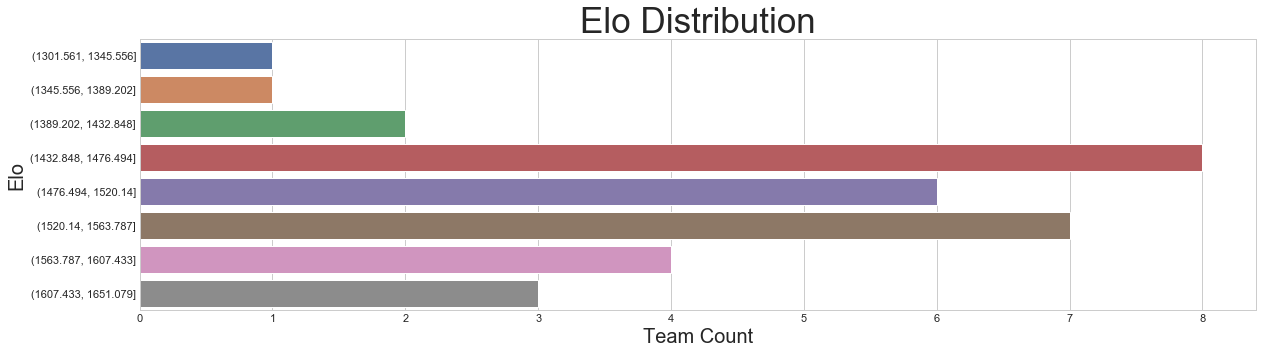

In [75]:
data_bin = pd.DataFrame()
data_bin['elo1'] = pd.cut(season['elo1'], 8)

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize = (20, 5)) 
sns.countplot(y = "elo1", data = data_bin);
plt.title('Elo Distribution', fontsize=35)
plt.ylabel('Elo', fontsize=20)
plt.xlabel('Team Count', fontsize=20);

The elo values are clearly skewed toward the upper half of the range which could be because there really isn't a floor on skill level<br>